In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from joblib import dump, load
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KDTree, KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.estimator_checks import check_estimator

df_train = pd.read_csv("train.csv", index_col='id')
df_test = pd.read_csv("test.csv", index_col='id')
df_features = pd.read_csv("features.csv")

# 'Score' histogram

На гистограмме наблюдается разбиение значений 'score' на кластеры. Возможно, стоит свести задачу регрессии к задаче классификации?

Cluster centers: [0.09 0.32 0.54 0.77]


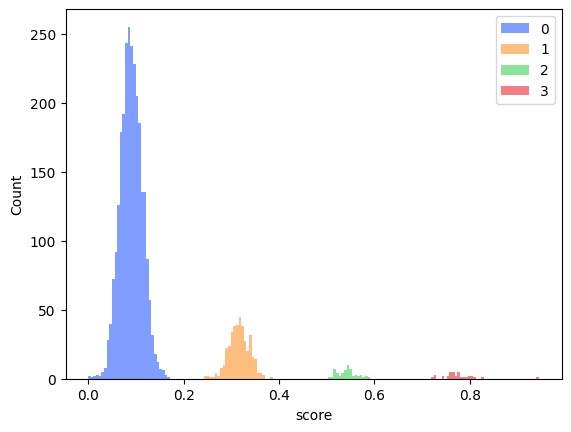

In [2]:
kmeans = KMeans(n_clusters=4, n_init=10).fit(df_train['score'].values.reshape(-1, 1))

# Sort clusters and re-label data
cc = kmeans.cluster_centers_.flatten()
cc_order = np.argsort(cc)
cc = cc[cc_order]
labels = np.nonzero(cc_order == kmeans.labels_[:, None])[1]
print(f"Cluster centers: {cc.round(2)}")

sns.histplot(df_train, x='score', hue=labels, palette='bright', edgecolor='none');

# Mapbox

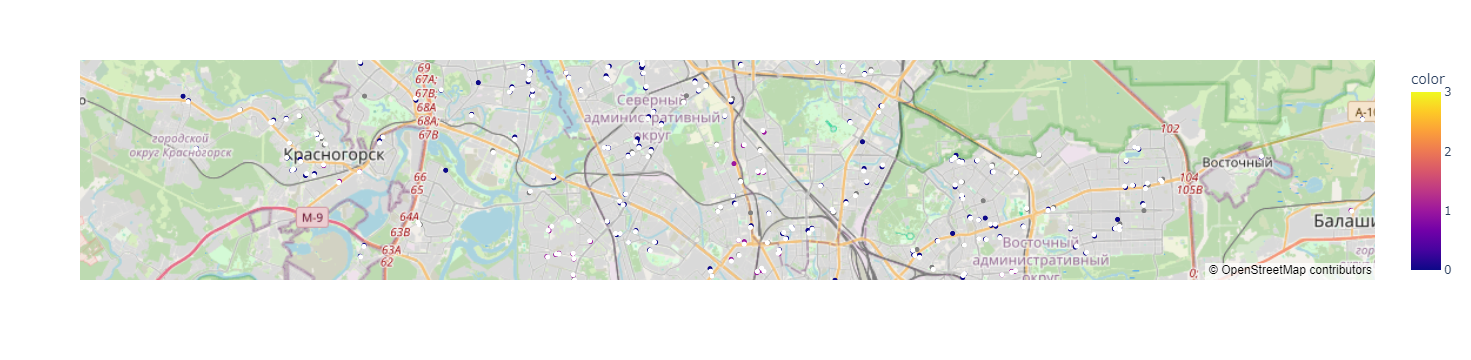

In [3]:
fig = px.scatter_mapbox(df_train, lat='lat', lon='lon', color=labels, hover_data='score')
fig_test = px.scatter_mapbox(df_test, lat='lat', lon='lon', color_discrete_sequence=['gray'])
fig_features = px.scatter_mapbox(df_features, lat='lat', lon='lon', color_discrete_sequence=['white'])

fig.add_traces([fig_test.data[0], fig_features.data[0]])
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Здесь цветными точками обозначены тренировочные данные, серыми - тестовые данные, а белыми - данные из "features.csv". Обращаем внимание, что рядом с каждой точкой из тренировочных и тестовых данных есть соответствующая ближайшая точка из "features.csv". Это позволяет взаимно (и почти однозначно) сопоставить тренировочные и тестовые точки с признаками из "features.csv". Для сопоставления ближайших точек воспользуемся алгоритмом KDTree.

In [4]:
tree = KDTree(df_features[['lat', 'lon']])

i = tree.query(df_train[['lat', 'lon']], k=1, return_distance=False).flatten()
matching_features = df_features.iloc[i].reset_index(drop=True).loc[:, '0':]
df_train = pd.concat([df_train[['lat', 'lon']], matching_features, df_train['score']], axis=1)
df_train.index.name = 'id'

i = tree.query(df_test[['lat', 'lon']], k=1, return_distance=False).flatten()
matching_features = df_features.iloc[i].reset_index(drop=True).loc[:, '0':]
df_test = pd.concat([df_test[['lat', 'lon']].reset_index(drop=True), matching_features], axis=1).set_index(df_test.index)
df_test.index.name = 'id'

На всякий случай проверим: вдруг среди признаков из features есть какой-нибудь, который кореллирует со 'score'?

In [5]:
df_train.corr().loc['lat':'362', 'score'].max()

0.22338622536579378

Такого признка, увы, не оказалось =(

# Cross-validation & baseline

Для оценки всех моделей применим пятикратную кроссвалидацию. Стратифицируем разбиение на выборки по найденным ранее кластерам.

В качестве бейзлайна рассчитаем MSE при использовании среднего значения в качестве модели.

In [6]:
X, y = df_train[['lat', 'lon']], df_train['score']
scores = -cross_val_score(
    DummyRegressor(strategy='mean'), X, y,
    scoring='neg_mean_squared_error',
    cv=StratifiedKFold().split(X, labels),
)
print(f"Baseline MSE: {scores.mean():.4f} ± {scores.std():.1g}")

Baseline MSE: 0.0141 ± 0.0002


# KNeighborsRegressor

In [7]:
X, y = df_train[['lat', 'lon']], df_train['score']
KNNReg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={'n_neighbors': np.arange(1, 10), 'weights': ['uniform', 'distance']},
    scoring='neg_mean_squared_error',
    cv=StratifiedKFold().split(X, labels),
).fit(X, y)
df_best_fit = pd.DataFrame.from_dict(KNNReg.cv_results_).sort_values('rank_test_score').head(1).squeeze()
score_mean, score_std = -df_best_fit['mean_test_score'], df_best_fit['std_test_score']
print(f"Best KNN regressor parameters: {df_best_fit['params']}")
print(f"MSE: {score_mean:.4f} ± {score_std:.1g}")

Best KNN regressor parameters: {'n_neighbors': 7, 'weights': 'distance'}
MSE: 0.0059 ± 0.0004


# KNeighborsClassifierRegressor

Попробуем объединить классификатор и регрессор на ближайших соседях. Каждая точка в данной задаче параметризуется и значением (score), и меткой класса (label). Сначала по обучающей выборке строим модель KMeans. Затем, для каждой валидационной точки определяем её класс с помощью KNeighborsClassifier, и уже в конце определяем её значение 'score' методом KNeighborsRegressor только среди точек её класса.

In [8]:
class KNeighborsClassifierRegressor(BaseEstimator):
    
    def __init__(self,
                 KMeans_n_clusters=4, KMeans_n_init=10,
                 classifier_n_neighbors=5, classifier_weights='distance',
                 regressor_n_neighbors=1, regressor_weights='distance'):
        self.KMeans_n_clusters = KMeans_n_clusters
        self.KMeans_n_init = KMeans_n_init
        self.classifier_n_neighbors = classifier_n_neighbors
        self.classifier_weights = classifier_weights
        self.regressor_n_neighbors = regressor_n_neighbors
        self.regressor_weights = regressor_weights

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)

        # Train a k-means model, sort clusters and re-label data
        kmeans = KMeans(
            n_clusters=self.KMeans_n_clusters, n_init=self.KMeans_n_init
        ).fit(y.reshape(-1, 1))
        cc = kmeans.cluster_centers_.flatten()
        cc_order = np.argsort(cc)
        cc = cc[cc_order]
        labels = np.nonzero(cc_order == kmeans.labels_[:, None])[1]

        # Train a KNeighborsClassifier model
        self.clf = KNeighborsClassifier(
            n_neighbors=self.classifier_n_neighbors, weights=self.classifier_weights
        ).fit(X, labels)

        # Train KNeighborsRegressor models
        self.regs = []
        for i in range(self.KMeans_n_clusters):
            self.regs.append(KNeighborsRegressor(
                n_neighbors=self.regressor_n_neighbors, weights=self.regressor_weights
            ).fit(X[labels==i], y[labels==i]))
        
        self.is_fitted_ = True
        return self

    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')

        labels = self.clf.predict(X)
        y = np.zeros_like(labels, dtype=float)
        for i in range(self.KMeans_n_clusters):
            if any(label := (labels == i)):
                y[label] = self.regs[i].predict(X[label])
        
        return y

X, y = df_train[['lat', 'lon']], df_train['score']
KNNClfReg = RandomizedSearchCV(
    KNeighborsClassifierRegressor(),
    param_distributions={
        'classifier_n_neighbors': np.arange(1, 10), 'classifier_weights': ['uniform', 'distance'],
        'regressor_n_neighbors': np.arange(1, 10), 'regressor_weights': ['uniform', 'distance'],
    },
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=StratifiedKFold().split(X, labels),
    random_state=2006,
).fit(X, y)
df_best_fit = pd.DataFrame.from_dict(KNNClfReg.cv_results_).sort_values('rank_test_score').head(1).squeeze()
score_mean, score_std = -df_best_fit['mean_test_score'], df_best_fit['std_test_score']
print(f"Best KNN regressor parameters: {df_best_fit['params']}")
print(f"MSE: {score_mean:.4f} ± {score_std:.1g}")

Best KNN regressor parameters: {'regressor_weights': 'uniform', 'regressor_n_neighbors': 7, 'classifier_weights': 'distance', 'classifier_n_neighbors': 2}
MSE: 0.0067 ± 0.0008


Странно, но результат стал хуже по сравнению с простым случаем с одним регрессором.

# RandomForestRegressor, GradientBoostingRegressor

Далее попробуем при обучении модели использовать признаки из "features.csv". Для понижения размерности используем МГК. Кроме KNN также попробуем использовать случайный лес и градиентный бустинг.

In [9]:
class UniversalEstimator(BaseEstimator):
    
    def __init__(self,
                 n_components=10,
                 use_PCA=True,
                 model=KNeighborsRegressor,
                 n_neighbors=7,
                 weights='distance'):
        self.n_components=n_components
        self.use_PCA = use_PCA
        self.model = model
        self.n_neighbors = n_neighbors
        self.weights = weights

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)

        if self.n_components > 0:
            if self.use_PCA:
                features = StandardScaler().fit_transform(X[:, 2:])
                self.pca = PCA(n_components=self.n_components).fit(features)
                features = self.pca.transform(features)
                X = np.concatenate((X[:, [0, 1]], features), axis=1)
            else:
                X = X[:, :2+self.n_components]
        else:
            X = X[:, [0, 1]]

        if self.model == KNeighborsRegressor:
            self.model = self.model(n_neighbors=self.n_neighbors,
                                    weights=self.weights).fit(X, y)
        else:
            self.model = self.model().fit(X, y)
        
        self.is_fitted_ = True
        return self

    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')

        if self.n_components > 0:
            if self.use_PCA:
                features = self.pca.transform(X[:, 2:])
                X = np.concatenate((X[:, [0, 1]], features), axis=1)
            else:
                X = X[:, :2+self.n_components]
        else:
            X = X[:, [0, 1]]

        y = self.model.predict(X)

        return y

X = df_train.drop(columns='score')
y = df_train['score']
model = RandomizedSearchCV(
    UniversalEstimator(),
    param_distributions={
        'n_components': np.arange(5),
        'use_PCA': [True, False],
        'model': [KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor],
    },
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=StratifiedKFold().split(X, labels),
    random_state=2006,
    n_jobs=-1,
).fit(X, y)
df_best_fit = pd.DataFrame.from_dict(model.cv_results_).sort_values('rank_test_score').head(1).squeeze()
score_mean, score_std = -df_best_fit['mean_test_score'], df_best_fit['std_test_score']
print(f"Best KNN regressor parameters: {df_best_fit['params']}")
print(f"MSE: {score_mean:.4f} ± {score_std:.1g}")

Best KNN regressor parameters: {'use_PCA': True, 'n_components': 0, 'model': <class 'sklearn.neighbors._regression.KNeighborsRegressor'>}
MSE: 0.0059 ± 0.0004


К сожалению, улучшить результат не удалось. Поиск по гиперпараметрам вернул параметры первой модели.

# Сохранение модели

In [10]:
dump(KNNReg.best_estimator_, 'model.joblib');

# Загрузка модели и предсказание по тестовым данным

In [12]:
model = load('model.joblib')
X = df_test[['lat', 'lon']]
y = model.predict(X)
submission = pd.DataFrame(data=y, index=df_test.index, columns=['score'])
submission.to_csv('submission.csv')